In [98]:
# CartPole 
# Policy Gradient: REINFORCE Softmax 
# Discrete Policy 
# Use Tensorflow

# solved

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
# observation 4, action 0 or 1
n_observation = 4
n_action = 2
n_hidden = 10

[2017-07-11 16:15:52,852] Making new env: CartPole-v0


In [99]:
# policy network tensorflow
tf_obs = tf.placeholder(tf.float32, [None, n_observation])
tf_act = tf.placeholder(tf.int32, [None, ])
tf_v = tf.placeholder(tf.float32, [None, ])
# tf_inprobs = tf.placeholder(tf.float32, [None, n_action])

# layers
W1 = tf.Variable(tf.random_normal([n_observation, n_hidden]))
b1 = tf.Variable(tf.random_normal([n_hidden]))
fc1 = tf.nn.relu(tf.matmul(tf_obs, W1))

W2 = tf.Variable(tf.random_normal([n_hidden, n_action]))
b2 = tf.Variable(tf.random_normal([n_action]))

out = tf.matmul(fc1, W2)
tf_prob = tf.nn.softmax(out)

# loss
# in one episode: each step can be considered as the first step, the J(theta) is 
# still the first step of V
log_prob = tf.reduce_sum(-tf.log(tf_prob) * tf.one_hot(tf_act, n_action), 1)
#log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=tf_act)
loss = tf.reduce_mean(tf.mul(log_prob, tf_v))   # tf.multiply in new version
# train
trainer = tf.train.AdamOptimizer(0.01).minimize(loss)
# init
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [96]:
# REINFORCE algorithm, update distribution parameters after one episode
gamma = 0.99
steplog = []
rsumlog = []
for episode in range(1000):
    slog = []
    alog = []
    rlog = []
    plog = []
    rsum = 0
    s = env.reset()
    for step in range(200):
        # feed policy network
        prob = sess.run(tf_prob, feed_dict={tf_obs:[s]})[0]
        # choose action by probability
        action = np.random.choice([0, 1], p=prob)
        s1, r, d, info = env.step(action)
        rsum += r
        plog.append(prob)
        slog.append(s)
        alog.append(action)
        rlog.append(r)
        
        s = s1
        
        #env.render()
        
        if d:
            break
    rsumlog.append(rsum)
    
    # calculate return v
    v = np.zeros([len(rlog)])
    v[-1] = rlog[-1]
    for i in range(len(rlog)):
        v[-i-1] = rlog[-i-1] + gamma * v[-i]
    # normalize return v
    v -= np.mean(v)
    v /= np.std(v)
        
    # reinforce update parameter theta
    # batch update
    sess.run(trainer, feed_dict={tf_obs:slog, tf_act:alog, tf_v:v})
    
    steplog.append(step)
print 'Training Done!'

Training Done!


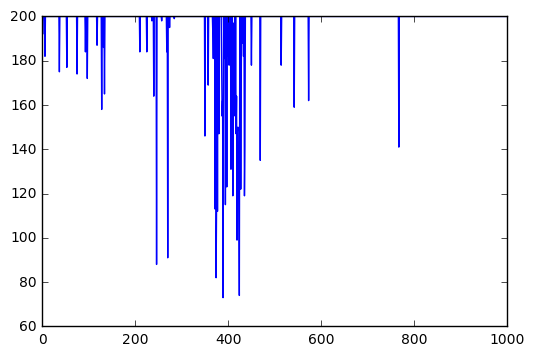

In [97]:
plt.plot(rsumlog)
plt.show()

In [82]:
sess.run(tf_prob, feed_dict={tf_obs:slog, tf_act:alog, tf_v:v})

array([[  9.99939203e-01,   6.08147311e-05],
       [  9.99999285e-01,   6.81879612e-07],
       [  1.00000000e+00,   7.99091637e-09],
       [  1.00000000e+00,   9.59106544e-11],
       [  1.00000000e+00,   1.15726406e-12],
       [  1.00000000e+00,   1.38100785e-14],
       [  1.00000000e+00,   1.60813970e-16],
       [  1.00000000e+00,   1.80960317e-18],
       [  1.00000000e+00,   1.95772826e-20]], dtype=float32)

In [86]:
sess.run(b2)

array([-0.00798257,  0.77247661], dtype=float32)